<a href="https://colab.research.google.com/github/Jia-wei-liao/NPDE_final_project/blob/main/DRM_Poisson2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jia-Wei, Liao (jw.sc09@nycu.edu.tw)
# Final Project of Numerical Methods for Partial Differential Equations 2021

In [2]:
import random, time, csv, os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input

# Set up the Neural Network

In [3]:
class Residual_block(tf.keras.Model):
  def __init__(self, n_Neural):
    super(Residual_block, self).__init__()
    self.Dense1 = Dense(n_Neural)
    self.Dense2 = Dense(n_Neural)
  
  def call(self, inputs):
    x = self.Dense1(inputs)
    x = tf.nn.relu(x)**3
    x = self.Dense2(x)
    x = x + tf.nn.relu(x)**3

    return x


class ResNet(tf.keras.Model):
  def __init__(self):
    super(ResNet, self).__init__()
    self.RB1 = Residual_block(20)
    self.RB2 = Residual_block(20)
    self.RB3 = Residual_block(20)
    self.FinalLayer = Dense(1)

    self.input_layer = Input(shape=(2))
    self.outputs = self.call(self.input_layer)

    super(ResNet, self).__init__(inputs=self.input_layer, outputs=self.outputs)
    
  def call(self, inputs, training=True):
    x = self.RB1(inputs)
    x = self.RB2(x)
    x = self.RB3(x)
    x = self.FinalLayer(x)

    return x

Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
residual_block (Residual_blo (None, 20)                480       
_________________________________________________________________
residual_block_1 (Residual_b (None, 20)                840       
_________________________________________________________________
residual_block_2 (Residual_b (None, 20)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


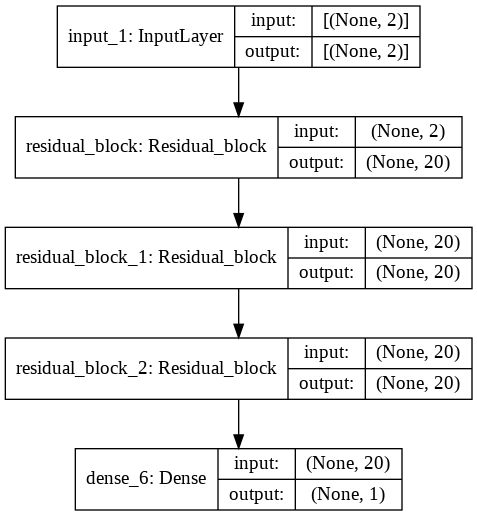

In [4]:
model = ResNet()
model.build((None, 2))
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

# Set the Parameter

In [5]:
epochs = 5000
Lambda = 5000
lr = 5e-4
optimizer = tf.keras.optimizers.Adam(lr)
mse = tf.keras.losses.MeanSquaredError()
N = 500  # number of interior sample point
M = 100  # number of boundary sample point

test_period = 500
save_period = 1000
save_weight = False
save_loss = False
weight_path = 'DRM_Poisson2DWeight'

if not os.path.isdir(weight_path):
  os.makedirs(weight_path)

# Define the function and exact solution

In [6]:
# def f(X):
#   x, y = X[:, 0], X[:, 1]
#   return 4+x*0+y*0


# def u_exact(X):
#   x, y = X[:, 0], X[:, 1]
#   return x**2+y**2


def f(X):
  x, y = X[:, 0], X[:, 1]
  return np.e**x*np.sin(np.pi*y)*(1-np.pi**2)


def u_exact(X):
  x, y = X[:, 0], X[:, 1]
  return np.e**x * np.sin(np.pi*y)

In [7]:
def generate_interior_point(num):
  sample = tf.random.uniform((num,2), minval=0, maxval=1, dtype=tf.dtypes.float32)
  return sample


def generate_boundary_point(num):
  left = np.random.rand(10,1)
  right = np.random.randint(0, 2, (10,1))
  random = np.concatenate([left, right], axis=1)
  change = np.random.choice(a=[True, False], size=(10))
  random[change, 0], random[change, 1] = random[change, 1], random[change, 0]
  random = tf.constant(random, dtype=tf.float32)
  return random


def BdyLoss(Xb, model, u_exact):
  U = model(Xb)
  u = u_exact(Xb)
  return mse(U, u)


def get_MeanLoss(List, keys):
  result = {}
  for key in keys:
    result[key] = np.mean([e[key] for e in List])
    
  return result


def save_csv(file_name, dict_list, key_list):
  with open(file_name, 'w', newline ='') as f:
    writer = csv.DictWriter(f, fieldnames = key_list)
    writer.writeheader()
    writer.writerows(dict_list)

# Training function

In [8]:
def Training(model, N, M, Loss_list, tic):
  with tf.GradientTape() as t2:
    with tf.GradientTape() as t1:
      X, Xb = generate_interior_point(N), generate_boundary_point(M)
      t1.watch(X)
      U = model(X)
    
    # Gradient
    DU = t1.gradient(U, X)
    DUNorm2 = tf.reduce_sum(tf.pow(DU, 2), axis=1)
    F = f(X)
    
    Li = tf.reduce_mean(DUNorm2/2 + F*U) # tf.reduce_mean(tf.math.abs(DUNorm2/2 + F*U))
    Lb = BdyLoss(Xb, model, u_exact)/M
    loss = Li + Lb*Lambda
    Loss_list.append({'InteriorLoss': Li.numpy(), 'BoundaryLoss': Lb.numpy(), 'TotalLoss': loss.numpy()})

  grads = t2.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  if ep%100==1:
    print(f'Epoch: {ep}, Time: {time.time()-tic:.0f}, InteriorLoss: {Li:.8f}, BoundaryLoss: {Lb:.8f}, TotalLoss: {float(loss):.8f}')

# Testing function

In [9]:
def PlotMesh(x, y, u, title):
  u = u[:-1, :-1]
  levels = MaxNLocator(nbins=15).tick_values(u.min(), u.max())
  cmap = plt.get_cmap('YlGnBu')
  im = plt.pcolormesh(x, y, u, cmap=cmap)
  plt.colorbar(im)
  plt.title(title)


def PointwiseError(U, u, method):
  if method == 'abs':
    return abs(U-u)
  
  if method == 'relative':
    return abs(U-u)/abs(u+1e-8)


def compute_error(U, u, method):
  abs_error = abs(U-u)

  if method == 'InfNorm':
    return np.max(abs_error)

  if method == 'TwoNorm':
    return np.sqrt(np.mean(abs_error**2))

  if method == 'Relative':
    return np.sqrt(np.mean(abs_error**2))/np.sqrt(np.mean(u**2))


def Testing(x, y, model):
  [xx, yy] = np.meshgrid(x, y)
  xx = xx.reshape(-1,1)
  yy = yy.reshape(-1,1)
  X = np.hstack([xx,yy])

  U = np.array(model(X)).reshape(100,100)
  u = u_exact(X).reshape(100,100)
  abs_error = PointwiseError(U, u, 'abs')
  relative_error = PointwiseError(U, u, 'relative')

  plt.figure(figsize=(10,8))
  plt.subplot(2,2,1)
  PlotMesh(x, y, U, 'DRM')
  plt.subplot(2,2,2)
  PlotMesh(x, y, u, 'exact')
  plt.subplot(2,2,3)
  PlotMesh(x[1:99], y[1:99], abs_error[1:99, 1:99], 'error')
  plt.subplot(2,2,4)
  PlotMesh(x[1:99], y[1:99], relative_error[1:99, 1:99], 'relative error')
  plt.show()
  
  Inf = compute_error(U, u, 'InfNorm')
  Two = compute_error(U, u, 'TwoNorm')
  Relative = compute_error(U, u, 'Relative')
  print(f'InfNorm: {Inf:.8f}, TwoNorm: {Two:.8f}, Relative: {Relative:.8f}')


x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

# Training and Testing process

Epoch: 1, Time: 1, InteriorLoss: -0.00000000, BoundaryLoss: 0.02082174, TotalLoss: 104.10870361
Epoch: 101, Time: 3, InteriorLoss: -3.99358392, BoundaryLoss: 0.00282349, TotalLoss: 10.12387180
Epoch: 201, Time: 6, InteriorLoss: -5.74345779, BoundaryLoss: 0.00582513, TotalLoss: 23.38221741
Epoch: 301, Time: 8, InteriorLoss: -3.63195109, BoundaryLoss: 0.00468004, TotalLoss: 19.76823044
Epoch: 401, Time: 11, InteriorLoss: -3.06086683, BoundaryLoss: 0.00215460, TotalLoss: 7.71212053


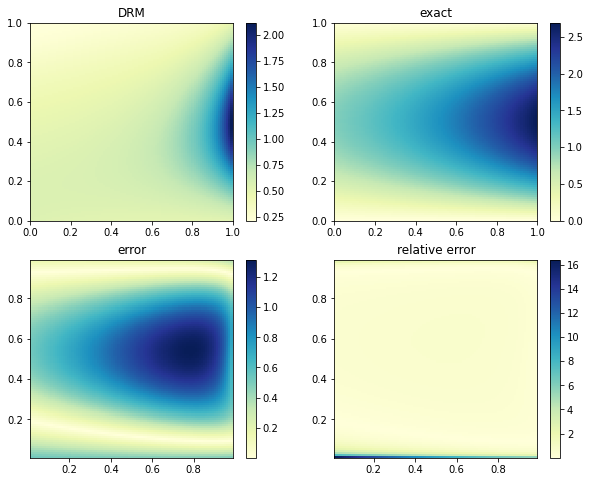

InfNorm: 1.31152253, TwoNorm: 0.66477830, Relative: 0.52781887
Epoch: 501, Time: 14, InteriorLoss: -2.92766333, BoundaryLoss: 0.00157162, TotalLoss: 4.93046045
Epoch: 601, Time: 16, InteriorLoss: -2.29832458, BoundaryLoss: 0.00155511, TotalLoss: 5.47722006
Epoch: 701, Time: 19, InteriorLoss: -2.88045955, BoundaryLoss: 0.00078143, TotalLoss: 1.02667665
Epoch: 801, Time: 21, InteriorLoss: -2.59214401, BoundaryLoss: 0.00058632, TotalLoss: 0.33945203
Epoch: 901, Time: 24, InteriorLoss: -4.35242414, BoundaryLoss: 0.00050272, TotalLoss: -1.83884358


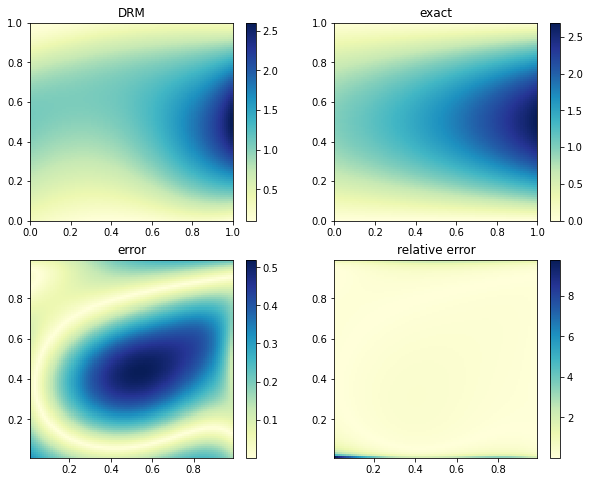

InfNorm: 0.51862815, TwoNorm: 0.24520077, Relative: 0.19468384
Epoch: 1001, Time: 27, InteriorLoss: -4.04680920, BoundaryLoss: 0.00026806, TotalLoss: -2.70652699
Epoch: 1101, Time: 30, InteriorLoss: -4.25187397, BoundaryLoss: 0.00023538, TotalLoss: -3.07498837
Epoch: 1201, Time: 32, InteriorLoss: -3.93821192, BoundaryLoss: 0.00025777, TotalLoss: -2.64934731
Epoch: 1301, Time: 35, InteriorLoss: -4.29344988, BoundaryLoss: 0.00047240, TotalLoss: -1.93146467
Epoch: 1401, Time: 37, InteriorLoss: -4.32089996, BoundaryLoss: 0.00017216, TotalLoss: -3.46007633


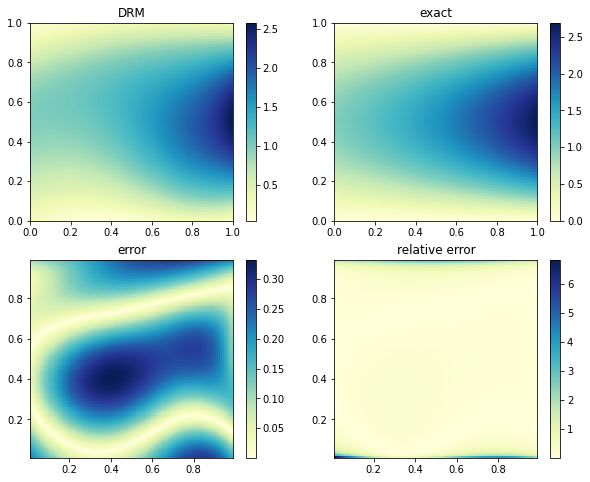

InfNorm: 0.33194621, TwoNorm: 0.17247011, Relative: 0.13693735
Epoch: 1501, Time: 40, InteriorLoss: -3.90432072, BoundaryLoss: 0.00036217, TotalLoss: -2.09345293
Epoch: 1601, Time: 43, InteriorLoss: -4.04024696, BoundaryLoss: 0.00026242, TotalLoss: -2.72815776
Epoch: 1701, Time: 45, InteriorLoss: -5.13170195, BoundaryLoss: 0.00018532, TotalLoss: -4.20508766
Epoch: 1801, Time: 48, InteriorLoss: -5.08455706, BoundaryLoss: 0.00046263, TotalLoss: -2.77139521
Epoch: 1901, Time: 50, InteriorLoss: -3.71380472, BoundaryLoss: 0.00014068, TotalLoss: -3.01042700


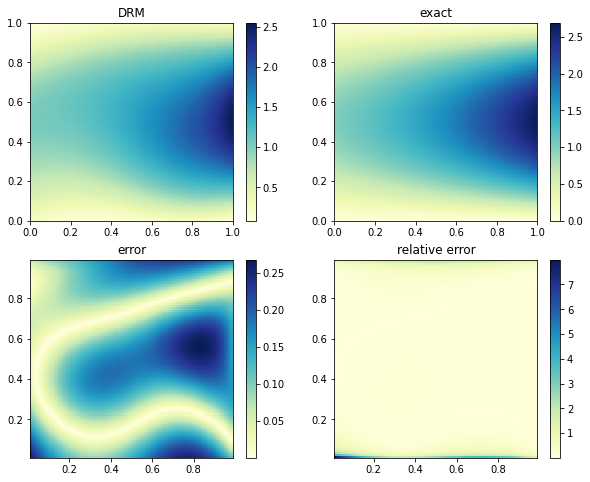

InfNorm: 0.27096379, TwoNorm: 0.13126351, Relative: 0.10422024
Epoch: 2001, Time: 54, InteriorLoss: -4.57723713, BoundaryLoss: 0.00017787, TotalLoss: -3.68790317
Epoch: 2101, Time: 56, InteriorLoss: -4.56906700, BoundaryLoss: 0.00024865, TotalLoss: -3.32579565
Epoch: 2201, Time: 59, InteriorLoss: -4.52458620, BoundaryLoss: 0.00021395, TotalLoss: -3.45484734
Epoch: 2301, Time: 61, InteriorLoss: -5.27309656, BoundaryLoss: 0.00029281, TotalLoss: -3.80902576
Epoch: 2401, Time: 64, InteriorLoss: -4.29464340, BoundaryLoss: 0.00015370, TotalLoss: -3.52612877


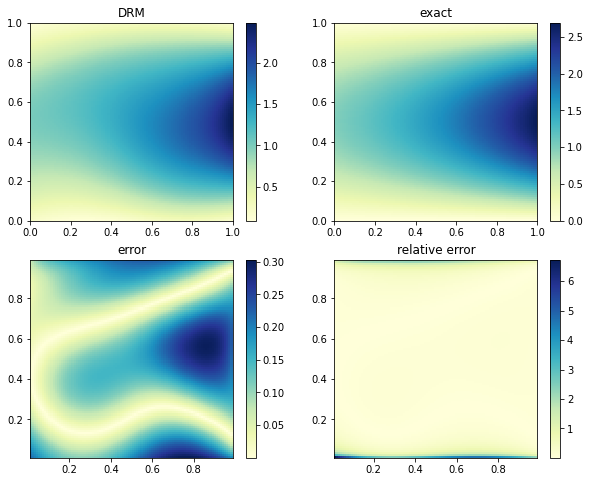

InfNorm: 0.31459931, TwoNorm: 0.13976200, Relative: 0.11096785
Epoch: 2501, Time: 67, InteriorLoss: -4.98490858, BoundaryLoss: 0.00026711, TotalLoss: -3.64937973
Epoch: 2601, Time: 69, InteriorLoss: -4.01413155, BoundaryLoss: 0.00015552, TotalLoss: -3.23653460
Epoch: 2701, Time: 72, InteriorLoss: -5.55540514, BoundaryLoss: 0.00016300, TotalLoss: -4.74041271
Epoch: 2801, Time: 74, InteriorLoss: -4.06591272, BoundaryLoss: 0.00021086, TotalLoss: -3.01159191
Epoch: 2901, Time: 77, InteriorLoss: -4.45333433, BoundaryLoss: 0.00031799, TotalLoss: -2.86337519


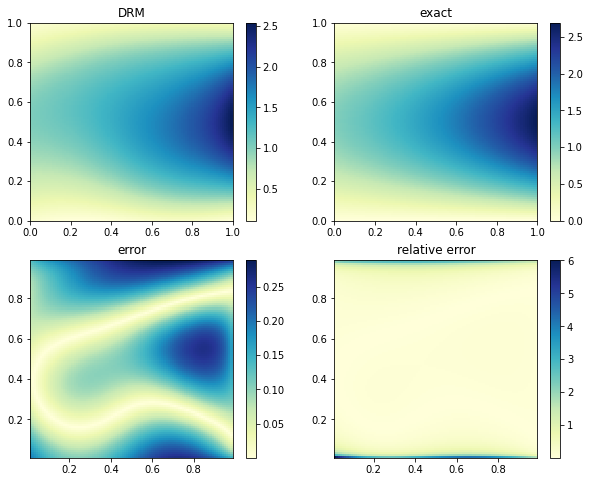

InfNorm: 0.30940184, TwoNorm: 0.13580650, Relative: 0.10782728
Epoch: 3001, Time: 80, InteriorLoss: -5.93780422, BoundaryLoss: 0.00035247, TotalLoss: -4.17545319
Epoch: 3101, Time: 82, InteriorLoss: -3.75621510, BoundaryLoss: 0.00018292, TotalLoss: -2.84162807
Epoch: 3201, Time: 85, InteriorLoss: -4.68718386, BoundaryLoss: 0.00022834, TotalLoss: -3.54549599
Epoch: 3301, Time: 87, InteriorLoss: -4.24599123, BoundaryLoss: 0.00025627, TotalLoss: -2.96465158
Epoch: 3401, Time: 90, InteriorLoss: -5.08078003, BoundaryLoss: 0.00024990, TotalLoss: -3.83129883


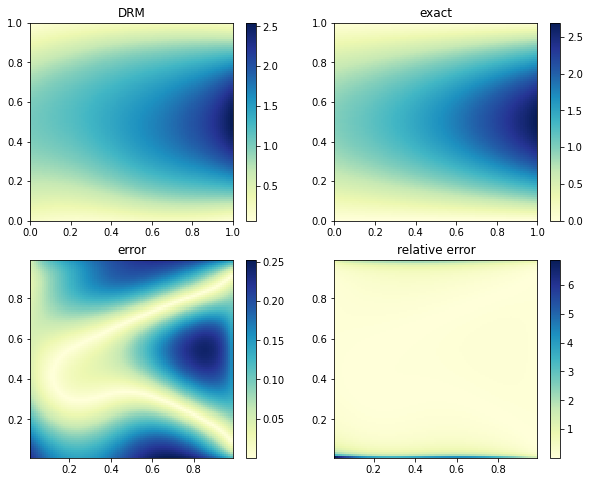

InfNorm: 0.26043832, TwoNorm: 0.12127691, Relative: 0.09629111
Epoch: 3501, Time: 93, InteriorLoss: -3.92178631, BoundaryLoss: 0.00015186, TotalLoss: -3.16249514
Epoch: 3601, Time: 96, InteriorLoss: -4.05233288, BoundaryLoss: 0.00027158, TotalLoss: -2.69440961
Epoch: 3701, Time: 98, InteriorLoss: -4.16080904, BoundaryLoss: 0.00031717, TotalLoss: -2.57497311
Epoch: 3801, Time: 101, InteriorLoss: -4.47551489, BoundaryLoss: 0.00036398, TotalLoss: -2.65561581
Epoch: 3901, Time: 103, InteriorLoss: -5.47036791, BoundaryLoss: 0.00022266, TotalLoss: -4.35709095


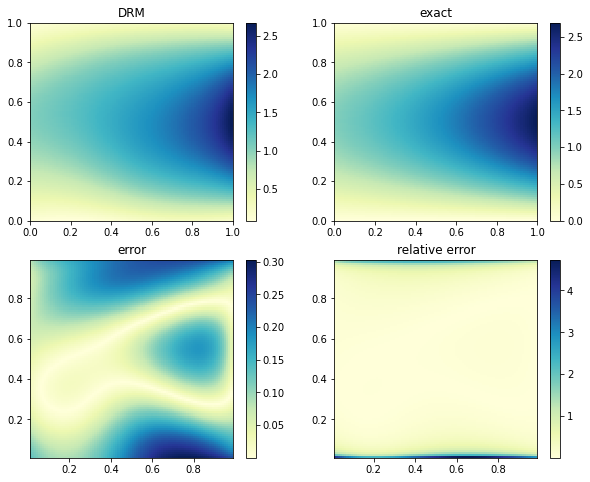

InfNorm: 0.31139469, TwoNorm: 0.12270201, Relative: 0.09742261
Epoch: 4001, Time: 106, InteriorLoss: -5.56665182, BoundaryLoss: 0.00027745, TotalLoss: -4.17941093
Epoch: 4101, Time: 109, InteriorLoss: -3.45018697, BoundaryLoss: 0.00032087, TotalLoss: -1.84581327
Epoch: 4201, Time: 111, InteriorLoss: -5.16865921, BoundaryLoss: 0.00019003, TotalLoss: -4.21853304
Epoch: 4301, Time: 114, InteriorLoss: -3.86982012, BoundaryLoss: 0.00027283, TotalLoss: -2.50568628
Epoch: 4401, Time: 116, InteriorLoss: -4.99711704, BoundaryLoss: 0.00024825, TotalLoss: -3.75584364


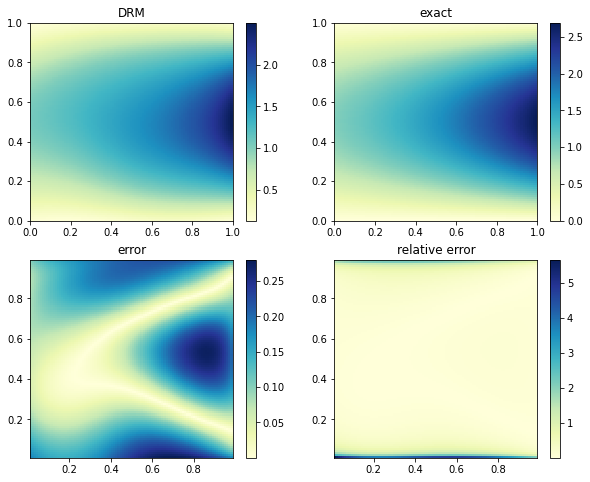

InfNorm: 0.29038012, TwoNorm: 0.13478446, Relative: 0.10701580
Epoch: 4501, Time: 120, InteriorLoss: -3.71062183, BoundaryLoss: 0.00035413, TotalLoss: -1.93995965
Epoch: 4601, Time: 122, InteriorLoss: -3.98955536, BoundaryLoss: 0.00018676, TotalLoss: -3.05576444
Epoch: 4701, Time: 125, InteriorLoss: -4.38177729, BoundaryLoss: 0.00021720, TotalLoss: -3.29578161
Epoch: 4801, Time: 128, InteriorLoss: -3.93515086, BoundaryLoss: 0.00022890, TotalLoss: -2.79065180
Epoch: 4901, Time: 130, InteriorLoss: -4.92843103, BoundaryLoss: 0.00033072, TotalLoss: -3.27481151


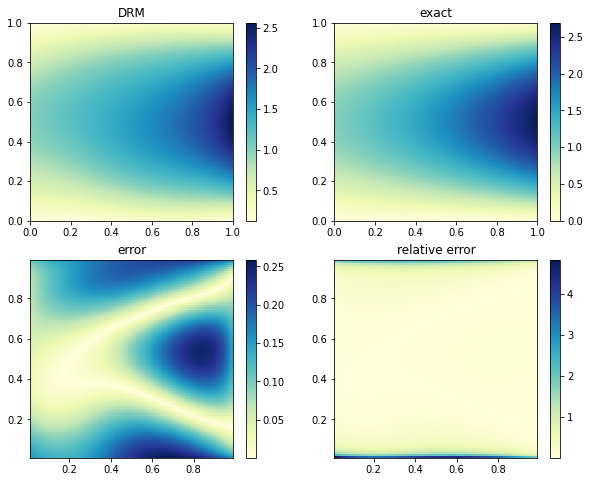

InfNorm: 0.26758134, TwoNorm: 0.12415329, Relative: 0.09857489


In [10]:
Loss_list = []
tic = time.time()
for ep in range(1, epochs+1):
  Training(model, N, M, Loss_list, tic)
  if ep % test_period ==0:
    Testing(x, y, model)

  # Save weight
  if save_weight and (ep==1 or ep % save_period ==0):
    filename = f'DRM_Poisson2DWeight_{ep}_{N}_{M}_{lr:.0e}'
    save_path = os.path.join(weight_path, filename + '.h5')
    model.save_weights(save_path)

# Save information

In [11]:
if save_loss:
  filename = f'DRM_Poisson2DWeight_{epochs}_{N}_{M}_{lr:.0e}'
  save_csv(filename+'.csv', Loss_list, ['InteriorLoss', 'BoundaryLoss', 'TotalLoss'])